In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2

C:\Users\jiaha\anaconda3\envs\tensorflow\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append("../..")
from segment_anything.modeling import TwoWayTransformer
from segment_anything.modeling.common import LayerNorm2d
from segment_anything.modeling.mask_decoder import MLP
from segment_anything.modeling.prompt_encoder import PositionEmbeddingRandom

In [3]:
device = 'cuda:0'

class MaskDecoder(nn.Module):
    def __init__(
        self,
        transformer_dim,
        transformer,
        num_multimask_outputs,
        activation = nn.GELU,
    ):
        super().__init__()
        self.transformer_dim = transformer_dim
        self.transformer = transformer
        self.num_multimask_outputs = num_multimask_outputs
        self.num_mask_tokens = num_multimask_outputs
        self.mask_tokens = nn.Embedding(self.num_mask_tokens, transformer_dim)
        self.output_upscaling = nn.Sequential(
            nn.ConvTranspose2d(transformer_dim, transformer_dim // 4, kernel_size=2, stride=2),
            LayerNorm2d(transformer_dim // 4),
            activation(),
            nn.ConvTranspose2d(transformer_dim // 4, transformer_dim // 8, kernel_size=2, stride=2),
            activation(),
        )
        self.output_hypernetworks_mlps = nn.ModuleList([
            MLP(transformer_dim, transformer_dim, transformer_dim // 8, 3)
                for i in range(self.num_mask_tokens)
        ])

    def forward(
        self,
        image_embeddings,
        image_pe,
    ):
        tokens = self.mask_tokens.weight.unsqueeze(0) # 1, 20, 256
        src = image_embeddings
        pos_src = image_pe
        b, c, h, w = src.shape

        # Run the transformer
        mask_tokens_out, src = self.transformer(src, pos_src, tokens)

        # Upscale mask embeddings and predict masks using the mask tokens
        src = src.transpose(1, 2).view(b, c, h, w)
        upscaled_embedding = self.output_upscaling(src)
        hyper_in_list = []
        for i in range(self.num_mask_tokens):
            hyper_in_list.append(self.output_hypernetworks_mlps[i](mask_tokens_out[:, i, :]))
        hyper_in = torch.stack(hyper_in_list, dim=1)
        b, c, h, w = upscaled_embedding.shape
        masks = (hyper_in @ upscaled_embedding.view(b, c, h * w)).view(b, -1, h, w)

        return masks

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.pe_layer = PositionEmbeddingRandom(128)
        self.mask_decoder = MaskDecoder(
            num_multimask_outputs=20,
            transformer=TwoWayTransformer(
                depth=2,
                embedding_dim=256,
                mlp_dim=2048,
                num_heads=8,
            ),
            transformer_dim=256,
        )

    def forward(self, img_embed):
        """ img_embed: (B, 256, 64, 64)
            @returns (B, C, 256, 256) logits
        """
        image_pe = self.pe_layer((64, 64)).unsqueeze(0)
        return self.mask_decoder(img_embed, image_pe)

model = Decoder()
model = model.to(device)

In [4]:
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate

class PeoplePosesDataset(Dataset):
    def __init__(self, mode="train", img_size=1024):
        assert mode in ("train", "val")
        self.mode = mode
        self.root = "../../datasets/people_poses"
        self.image_dir = os.path.join(self.root, f"{self.mode}_images")
        self.mask_dir = os.path.join(self.root, f"{self.mode}_segmentations")
        self.embed_dir = os.path.join(self.root, f"{self.mode}_embeds")
        with open(os.path.join(self.root, f"{self.mode}_id.txt"), 'r') as lf:
            self.data_list = [ s.strip() for s in lf.readlines() ]
        self.img_size = img_size

    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, index):
        """ embed: (1, 256, 64, 64)
            label: (1, 256, 256)
        """
        data = np.load(os.path.join(self.embed_dir, self.data_list[index] + ".npz"))
        embed = data['embed']
        embed = torch.as_tensor(embed)
        label = data['label']
        # NOTE(jiahang): uint8 cannot handle -1, other int fails F.interpolate
        label = torch.as_tensor(label).to(torch.float32)
        label = F.interpolate(label[None, None, ...], (256, 256), mode='nearest')
        return embed, label[0][0].to(torch.int64)

In [5]:
import os
from tqdm import tqdm
from torch.optim.lr_scheduler import SequentialLR, ConstantLR, ExponentialLR

dataset = PeoplePosesDataset()
dataloader = DataLoader(dataset, batch_size=24, shuffle=True)

def loss_fn(logits, labels):
    """ logits/labels: (B, C, 1024, 1024) """
    return F.cross_entropy(logits, labels, ignore_index=-1, reduction='mean')

def train_one_epoch(epoch_index):
    losses = []
    for data in (pbar := tqdm(dataloader)):
        embeds, labels = data
        embeds = embeds.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        logits = model(embeds)
        loss = loss_fn(logits, labels)
        losses.append(loss.detach().cpu().numpy())
        loss.backward()
        optimizer.step()
        pbar.set_description(f'loss: {loss}')
    print('Average Loss: {}'.format(np.mean(losses)))
    scheduler.step()

os.makedirs('v4', exist_ok=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.9)

for epoch in range(20):
    print('EPOCH {}: LR={}'.format(epoch, optimizer.param_groups[0]['lr']))

    model.train(True)
    train_one_epoch(epoch)

    model_path = 'v4/model_{}.pth'.format(epoch)
    torch.save(model.state_dict(), model_path)

EPOCH 0: LR=0.001


loss: 0.5940401554107666: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1270/1270 [22:05<00:00,  1.04s/it]


Average Loss: 0.9213780760765076
EPOCH 1: LR=0.0009000000000000001


loss: 0.6014803647994995: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1270/1270 [20:28<00:00,  1.03it/s]


Average Loss: 0.7386558651924133
EPOCH 2: LR=0.0008100000000000001


loss: 0.4961749315261841: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1270/1270 [22:23<00:00,  1.06s/it]


Average Loss: 0.6999505162239075
EPOCH 3: LR=0.000729


loss: 0.8416560292243958: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1270/1270 [23:52<00:00,  1.13s/it]


Average Loss: 0.6727073788642883
EPOCH 4: LR=0.0006561000000000001


loss: 0.9100601673126221: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1270/1270 [23:36<00:00,  1.12s/it]


Average Loss: 0.6541185975074768
EPOCH 5: LR=0.00059049


loss: 0.513882040977478: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1270/1270 [23:29<00:00,  1.11s/it]


Average Loss: 0.6333973407745361
EPOCH 6: LR=0.000531441


loss: 0.6169296503067017: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1270/1270 [23:27<00:00,  1.11s/it]


Average Loss: 0.6181331872940063
EPOCH 7: LR=0.0004782969


loss: 0.5471528768539429: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1270/1270 [23:24<00:00,  1.11s/it]


Average Loss: 0.6047726273536682
EPOCH 8: LR=0.00043046721


loss: 0.7119408845901489: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1270/1270 [23:17<00:00,  1.10s/it]


Average Loss: 0.5941262245178223
EPOCH 9: LR=0.000387420489


loss: 0.4361647069454193: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1270/1270 [23:10<00:00,  1.10s/it]


Average Loss: 0.579290509223938
EPOCH 10: LR=0.0003486784401


loss: 0.5164034366607666: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1270/1270 [23:28<00:00,  1.11s/it]


Average Loss: 0.5649146437644958
EPOCH 11: LR=0.00031381059609000004


loss: 0.4670385718345642: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1270/1270 [23:28<00:00,  1.11s/it]


Average Loss: 0.5508007407188416
EPOCH 12: LR=0.00028242953648100003


loss: 0.27429357171058655: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1270/1270 [23:26<00:00,  1.11s/it]


Average Loss: 0.5389607548713684
EPOCH 13: LR=0.00025418658283290005


loss: 0.2195831686258316: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1270/1270 [23:29<00:00,  1.11s/it]


Average Loss: 0.5214954018592834
EPOCH 14: LR=0.00022876792454961005


loss: 0.32655391097068787: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1270/1270 [23:48<00:00,  1.12s/it]


Average Loss: 0.5054287910461426
EPOCH 15: LR=0.00020589113209464906


loss: 0.8428499698638916: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1270/1270 [23:20<00:00,  1.10s/it]


Average Loss: 0.4904511272907257
EPOCH 16: LR=0.00018530201888518417


loss: 0.39816972613334656: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1270/1270 [26:17<00:00,  1.24s/it]


Average Loss: 0.47386103868484497
EPOCH 17: LR=0.00016677181699666576


loss: 0.5321853160858154: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1270/1270 [23:59<00:00,  1.13s/it]


Average Loss: 0.4584718644618988
EPOCH 18: LR=0.0001500946352969992


loss: 0.3455686569213867: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1270/1270 [23:27<00:00,  1.11s/it]


Average Loss: 0.4435376822948456
EPOCH 19: LR=0.0001350851717672993


loss: 0.479257732629776: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1270/1270 [23:32<00:00,  1.11s/it]

Average Loss: 0.429008424282074


## Validation

In [ ]:
model.load_state_dict(torch.load('v3/model_13.pth'))
model.eval()

In [6]:
val_dataset = PeoplePosesDataset(mode="val")
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [7]:
x, y = val_dataset[0]
x.shape, y.shape

(torch.Size([256, 64, 64]), torch.Size([256, 256]))

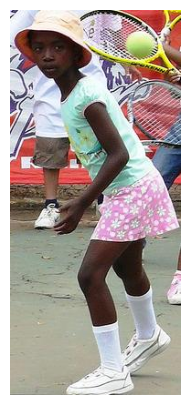

In [8]:
image = cv2.imread(os.path.join(val_dataset.image_dir, val_dataset.data_list[0] + ".jpg"))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('off')
plt.show()

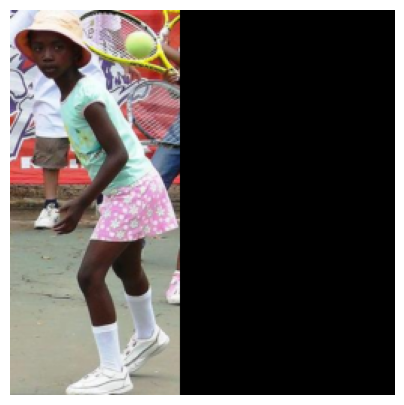

In [9]:
import sys
sys.path.append("../..")
from segment_anything.utils.transforms import ResizeLongestSide
size = 256
transform = ResizeLongestSide(size)

def preprocess(x):
    h, w = x.shape[-2:]
    padh = size - h
    padw = size - w
    x = F.pad(x, (0, padw, 0, padh))
    return x

def preprocess_image(image):
    image = transform.apply_image(image)
    H, W, C = image.shape
    image = torch.as_tensor(image)
    image = image.permute(2, 0, 1).contiguous().unsqueeze(0)
    image = preprocess(image)
    return image

prep = preprocess_image(image)
prep = prep[0].permute(1, 2, 0).numpy()
plt.figure(figsize=(5,5))
plt.imshow(prep)
plt.axis('off')
plt.show()

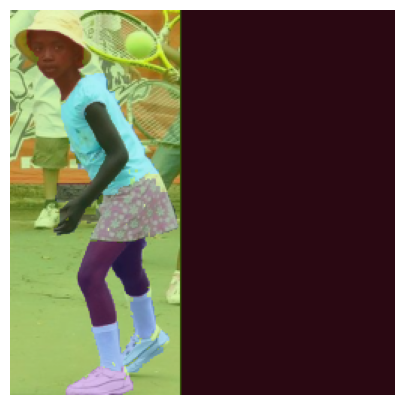

In [11]:
def gt_to_anns(mask_gt):
    labels = np.unique(mask_gt)
    anns = []
    for label in labels:
        mask = np.all(mask_gt == label, axis=-1)
        anns.append({
            'area': np.sum(mask),
            'segmentation': mask,
            'label': label
        })
    return anns

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

label = y.unsqueeze(2).cpu().numpy()
plt.figure(figsize=(5,5))
plt.imshow(prep)
show_anns(gt_to_anns(label))
plt.axis('off')
plt.show() 

In [12]:
with torch.no_grad():
    model.eval()
    logit = model(x.unsqueeze(0).to(device))
logit.shape

torch.Size([1, 20, 256, 256])

In [13]:
pred = logit.cpu().numpy().argmax(axis=1)
pred.shape

(1, 256, 256)

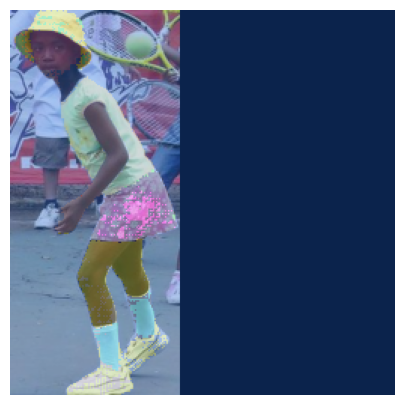

In [14]:
pred = np.transpose(pred, [1, 2, 0])
plt.figure(figsize=(5,5))
plt.imshow(prep)
show_anns(gt_to_anns(pred))
plt.axis('off')
plt.show() 

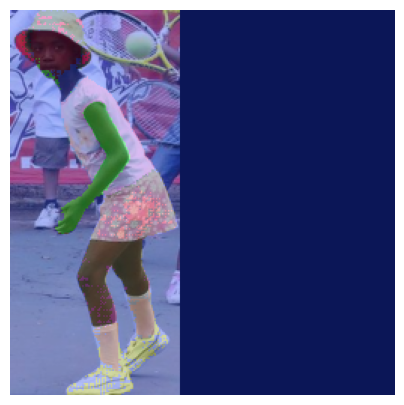

In [15]:
pred[label == -1] = 0
plt.figure(figsize=(5,5))
plt.imshow(prep)
show_anns(gt_to_anns(pred))
plt.axis('off')
plt.show() 

In [16]:
# NOTE(jiahang): this evaluation has bug, because it considered padding(-1)
(pred == label).mean()

0.3639678955078125

In [17]:
import pandas as pd

In [18]:
label_txt = """Background
Hat
Hair
Glove
Sunglasses
UpperClothes
Dress
Coat
Socks
Pants
Jumpsuits
Scarf
Skirt
Face
Left-arm
Right-arm
Left-leg
Right-leg
Left-shoe
Right-shoe"""
label_txt = label_txt.split('\n')
label_txt

['Background',
 'Hat',
 'Hair',
 'Glove',
 'Sunglasses',
 'UpperClothes',
 'Dress',
 'Coat',
 'Socks',
 'Pants',
 'Jumpsuits',
 'Scarf',
 'Skirt',
 'Face',
 'Left-arm',
 'Right-arm',
 'Left-leg',
 'Right-leg',
 'Left-shoe',
 'Right-shoe']

In [19]:
ious = []
pixels = []
for i in range(20):
    label_i = (label == i)
    pred_i = (pred == i)
    ious.append((label_i & pred_i).sum() / ((label_i | pred_i).sum() + 1e-6))
    pixels.append(label_i.sum())
print(np.mean(ious))
pd.DataFrame({ 'labels': label_txt, 'ious': ious, 'pixels': pixels })

0.21555077597883643


,labels,ious,pixels
0,Background,0.321758,18467
1,Hat,0.115326,540
2,Hair,0.000000,0
3,Glove,0.000000,0
4,Sunglasses,0.000000,0
5,UpperClothes,0.847610,2054
6,Dress,0.005556,1791
7,Coat,0.000000,0
8,Socks,0.690889,905
9,Pants,0.000000,0
